# Statistical & Machine Learning Methods (Assignment #8)

In [16]:
import pandas as pd

# Load datasets
baseline_df = pd.read_csv("patient_baseline.csv", sep='\t')
longitudinal_df = pd.read_csv("patient_longitudinal.csv", sep='\t')
treatment_df = pd.read_csv("patient_treatment.csv", sep='\t')

# Inspect the first few rows of each dataset
print(baseline_df.head())
print(longitudinal_df.head())
print(treatment_df.head())


   patient_id   age  sex   bmi  smoking  diabetes  bp_systolic  cholesterol  \
0           0  57.5    0  25.8        0         0        108.7        257.9   
1           1  47.9    0  23.2        0         0        149.4        155.9   
2           2  59.7    1  29.0        0         0        136.7        220.7   
3           3  72.8    1  34.6        0         1        141.0        205.7   
4           4  46.5    0  17.5        0         0        129.0        186.8   

   heart_rate  
0        79.3  
1        75.4  
2        85.0  
3        78.0  
4        95.2  
   patient_id  visit_date  bp_systolic  heart_rate  adverse_event   age  sex  \
0           0  2023-01-17        108.6        72.4              0  57.5  0.0   
1           0  2023-02-22        104.8        71.9              0  57.5  0.0   
2           0  2023-03-23        106.3        76.2              0  57.5  0.0   
3           0  2023-04-16        110.8        76.5              0  57.5  0.0   
4           0  2023-06-05    

In [17]:
# Convert visit_date to datetime
longitudinal_df['visit_date'] = pd.to_datetime(longitudinal_df['visit_date'], format='%Y-%m-%d')
longitudinal_df.set_index('visit_date', inplace=True)

# Check if there are any duplicate rows
duplicates = longitudinal_df.duplicated()
print("Any duplicates:", duplicates.any())

# Handle duplicates by aggregating, e.g., taking the mean of duplicates
# Group by patient_id and index (visit_date) to get the mean for duplicates
longitudinal_df = longitudinal_df.groupby(['patient_id', longitudinal_df.index]).mean()

# Reset the index to restore 'visit_date' as a column, then set it again as a DateTimeIndex
longitudinal_df = longitudinal_df.reset_index().set_index('visit_date')

# Handle missing values
longitudinal_df = longitudinal_df.interpolate()  # Linear interpolation as an example


Any duplicates: True


/var/folders/0c/lpwqndbd1wn2y0_gz1l1x3vr0000gn/T/ipykernel_75095/2023909959.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bp = longitudinal_df['bp_systolic'].resample('M').mean()


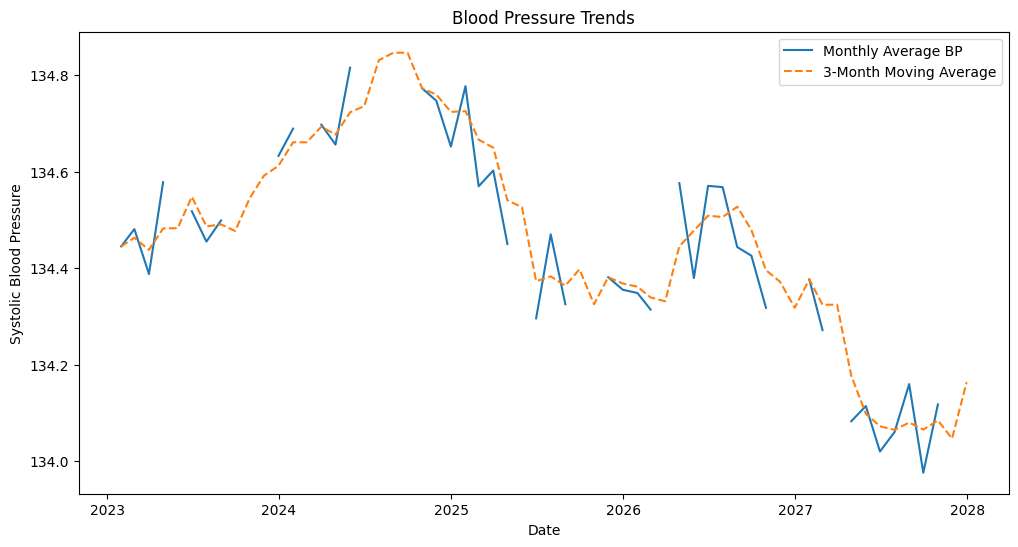

In [18]:
import matplotlib.pyplot as plt

# Resample to monthly frequency
monthly_bp = longitudinal_df['bp_systolic'].resample('M').mean()

# Calculate 3-month moving average
monthly_bp_ma = monthly_bp.rolling(window=3, min_periods=1).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label='Monthly Average BP')
plt.plot(monthly_bp_ma, label='3-Month Moving Average', linestyle='--')
plt.legend()
plt.title('Blood Pressure Trends')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.show()


# SBP increased and then decreased over time.

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        20:42:10   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

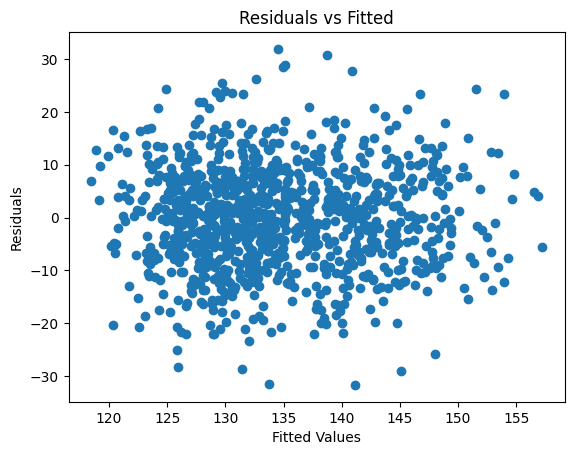

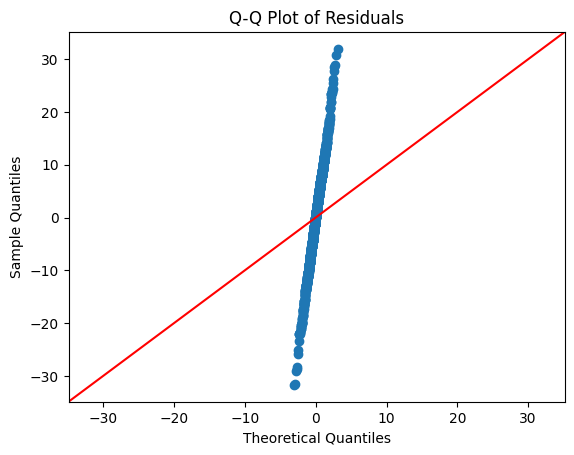

In [22]:
# Factors associated with baseline blood pressure
import statsmodels.api as sm

# Select predictors and target variable
X = baseline_df[['age', 'bmi', 'smoking', 'diabetes']]
X = sm.add_constant(X)  # Add constant term
y = baseline_df['bp_systolic']

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

# Diagnostic Plots
# Residuals vs Fitted
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()


# Age, BMI, smoking, diabetes are associated with blood pressure 

In [25]:
# Model treatment effectiveness
import numpy as np

# Select predictors and target variable for GLM
X_glm = treatment_df[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
X_glm = sm.add_constant(X_glm)
y_glm = treatment_df['outcome']

# Fit the GLM model
glm_model = sm.GLM(y_glm, X_glm, family=sm.families.Binomial()).fit()
print(glm_model.summary())

# Calculate Odds Ratios
odds_ratios = np.exp(glm_model.params)
print("Odds Ratios:")
print(odds_ratios)

# Check residual deviance
print("Residual Deviance:", glm_model.deviance)
print("Null Deviance:", glm_model.null_deviance)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Tue, 05 Nov 2024   Deviance:                       1312.8
Time:                        20:52:16   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

# Higher BMI had better treatment effectiveness, while having diabetes had lower treatment effectiveness.

In [26]:
# Machine learning task
## Step 1: Prepare the Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, RocCurveDisplay, confusion_matrix

# Load the treatment dataset
treatment_df = pd.read_csv("patient_treatment.csv", sep='\t')

# Define features and target
X = treatment_df[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y = treatment_df['outcome']


In [27]:
# Stratified split for training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [28]:
# Setup a pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create logistic regression model with regularization
log_reg = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)

# Build pipeline with scaler and logistic regression
pipeline = make_pipeline(
    StandardScaler(),
    SelectKBest(k='all'),  # Or use RFE(log_reg, n_features_to_select=3)
    log_reg
)


In [29]:
# Cross-validate 
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture multiple metrics
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

# Display cross-validation results
print("Cross-Validation Results:")
print(f"Accuracy: {scores['test_accuracy'].mean():.3f}")
print(f"Precision: {scores['test_precision'].mean():.3f}")
print(f"Recall: {scores['test_recall'].mean():.3f}")
print(f"ROC AUC: {scores['test_roc_auc'].mean():.3f}")


Cross-Validation Results:
Accuracy: 0.541
Precision: 0.430
Recall: 0.587
ROC AUC: 0.547



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       185
           1       0.41      0.52      0.46       115

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.52       300
weighted avg       0.55      0.53      0.54       300


Confusion Matrix:
[[99 86]
 [55 60]]


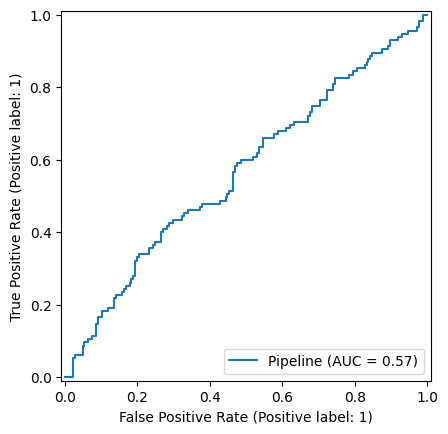

In [30]:
# Fit the model 
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # For ROC curve

# Generate classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Display ROC Curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)


In [31]:
# Hyperparameter turning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strengths
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation ROC AUC Score:", grid_search.best_score_)

# Update pipeline with the best estimator
best_pipeline = grid_search.best_estimator_


Best Parameters: {'logisticregression__C': 0.01}
Best Cross-Validation ROC AUC Score: 0.5596241881984267


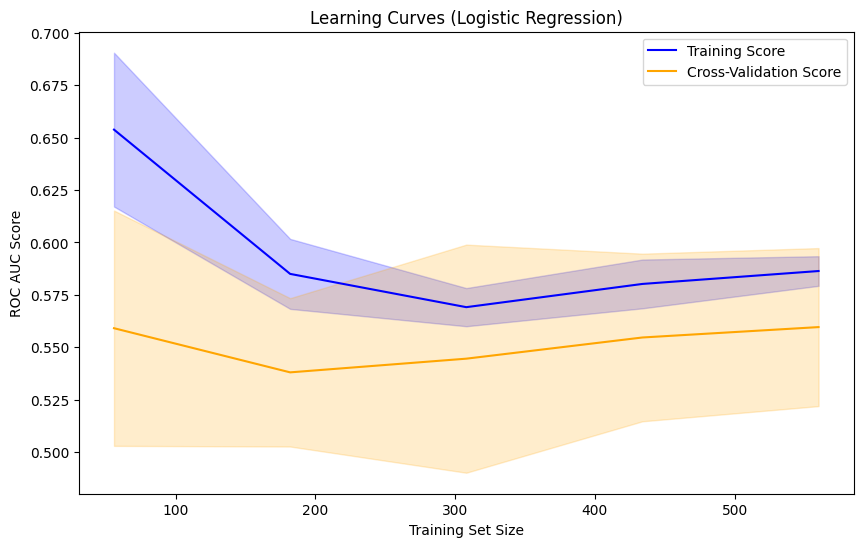

In [32]:
# Plot learning curves
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calculate the mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='orange')

# Plot the shaded areas for standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.2)

# Add labels and legend
plt.title('Learning Curves (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC Score')
plt.legend()
plt.show()
